In [1]:
from src.ModelTransfuser_cfg import *
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.patches as patches
import seaborn as sns

import numpy as np
import torch
from torch.utils.data import DataLoader

from scipy.stats import norm

import os

%matplotlib inline

# Load data

In [2]:
# --- Clean the data ---
# Chempy sometimes returns zeros or infinite values, which need to removed
def clean_data(x, y):
    # Remove all zeros from the training data
    index = np.where((y == 0).all(axis=1))[0]
    x = np.delete(x, index, axis=0)
    y = np.delete(y, index, axis=0)

    # Remove all infinite values from the training data
    index = np.where(np.isfinite(y).all(axis=1))[0]
    x = x[index]
    y = y[index]

    # Remove H from Elements
    y = np.delete(y, 2, 1)

    return x, y

In [3]:
"""
# --- Load in training data ---
path_training = os.getcwd() + '/data/Chempy_data/chempy_TNG_train_data.npz'
training_data = np.load(path_training, mmap_mode='r')

elements = training_data['elements']
train_x = training_data['params']
train_y = training_data['abundances']

train_x, train_y = clean_data(train_x, train_y)

# convert to torch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)

# --- add noise ---
pc_ab = 5 # percentage error in abundance

train_y_err = torch.ones_like(train_y)*float(pc_ab)/100.
train_y = norm.rvs(loc=train_y,scale=train_y_err)
train_y = torch.tensor(train_y).float()

train_data = torch.cat((train_x, train_y), 1)
"""

"\n# --- Load in training data ---\npath_training = os.getcwd() + '/data/Chempy_data/chempy_TNG_train_data.npz'\ntraining_data = np.load(path_training, mmap_mode='r')\n\nelements = training_data['elements']\ntrain_x = training_data['params']\ntrain_y = training_data['abundances']\n\ntrain_x, train_y = clean_data(train_x, train_y)\n\n# convert to torch tensors\ntrain_x = torch.tensor(train_x, dtype=torch.float32)\ntrain_y = torch.tensor(train_y, dtype=torch.float32)\n\n# --- add noise ---\npc_ab = 5 # percentage error in abundance\n\ntrain_y_err = torch.ones_like(train_y)*float(pc_ab)/100.\ntrain_y = norm.rvs(loc=train_y,scale=train_y_err)\ntrain_y = torch.tensor(train_y).float()\n\ntrain_data = torch.cat((train_x, train_y), 1)\n"

In [4]:
# ---  Load in the validation data ---
path_test = os.getcwd() + '/data/Chempy_data/chempy_TNG_val_data.npz'
val_data = np.load(path_test, mmap_mode='r')

val_x = val_data['params']
val_y = val_data['abundances']

val_x, val_y = clean_data(val_x, val_y)

# convert to torch tensors
val_x = torch.tensor(val_x, dtype=torch.float32)
val_y = torch.tensor(val_y, dtype=torch.float32)

# --- add noise ---
pc_ab = 5 # percentage error in abundance

val_y_err = torch.ones_like(val_y)*float(pc_ab)/100.
val_y = norm.rvs(loc=val_y,scale=val_y_err)
val_y = torch.tensor(val_y).float()

val_data = torch.cat((val_x, val_y), 1)

## Define ModelTransfuser

In [5]:
# Define the ModelTransfuser

# Time steps for the diffusion process
#T = 20
#t = torch.linspace(0, 1, T)

model = ModelTransfuser(14)
model = model.load('data/models/optuna2/Model_checkpoint.pickle')
device = "cuda:1"
temp = 4
cfg_alpha = 44.5

## Forward Diffusion

In [6]:
"""
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

t = torch.linspace(0, 1, T)
color = ['red', 'blue', 'green', 'purple', 'orange', 'black']

def animate(i):
    data_t = model.forward_diffusion_sample(train_data[:,:6], t[i])
    plt.cla()
    for n in range(data_t.shape[1]):
        plt.hist(data_t[:,n], bins=500, range=(-5,15), density=True, alpha=0.5, color=color[n])
    plt.xlim([-5,15])
    plt.ylim([0,1])
    plt.title(f"t={int(i)}")

"""
#ani = matplotlib.animation.FuncAnimation(fig, animate, frames=model.timesteps)

#writer = matplotlib.animation.PillowWriter(fps=20,
#                                metadata=dict(artist='Me'),
#                                bitrate=1800)
#ani.save('plots/theta_to_noise.gif', writer=writer)
"""
matplotlib.animation.FuncAnimation(fig, animate, frames=model.timesteps)
"""

'\nmatplotlib.animation.FuncAnimation(fig, animate, frames=model.timesteps)\n'

## Sampling

In [7]:
mask = torch.zeros_like(val_data[0])
mask[6:] = 1

data = val_data[:1000, mask.type(torch.bool)]

In [42]:
p=model.sample(data[343], condition_mask=mask, device=device, timesteps=100, temperature=1, cfg_alpha=None).to("cpu")

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


In [43]:
p.mean(axis=1)

tensor([[-2.2446, -2.8686, -0.3666,  0.5842,  0.5397,  5.9842,  0.1064, -0.1300,
          0.1745,  0.3624,  0.0413,  0.5628,  0.4325,  0.2868]])

In [44]:
p.std(axis=1)

tensor([[0.0367, 0.0541, 0.0501, 0.0102, 0.0162, 1.0507, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

In [45]:
val_data[343]

tensor([-2.2610, -2.8464, -0.2938,  0.5173,  0.2487,  3.7929,  0.1064, -0.1300,
         0.1745,  0.3624,  0.0413,  0.5628,  0.4325,  0.2868])

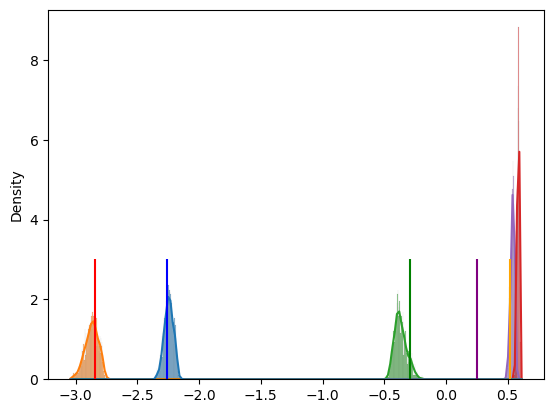

In [46]:
sns.histplot(p[0,:,:5].detach().numpy(), bins=1000, kde=True,color=['blue','red','green','orange','purple'], legend=False, stat='density')
plt.vlines(val_data[343,:5], 0, 3, color=['blue','red','green','orange','purple'])
#plt.vlines(val_data[1,0], 0, 10, color='red')
plt.show()

In [ ]:
"""
plt.rcParams["animation.html"] = "jshtml"
#plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

t = torch.linspace(0, 1, model.timesteps)
color = ['red', 'blue', 'green', 'purple', 'orange', 'black']

def animate(i):
    #data_t = model.forward_diffusion_sample(train_data[:,:6], t[i])
    data_t = model.x_t[0,i,:,:6].detach().numpy()
    plt.cla()
    for n in range(data_t.shape[1]):
        plt.hist(data_t[:,n], bins=500, range=(-5,15), density=True, alpha=0.5, color=color[n])
    plt.xlim([-5,15])
    plt.ylim([0,1])
    plt.title(f"t={int(i)}")
"""
"""
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=model.timesteps)

writer = matplotlib.animation.PillowWriter(fps=20,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save('../plots/theta_to_noise.gif', writer=writer)
"""
# matplotlib.animation.FuncAnimation(fig, animate, frames=model.timesteps)

KeyboardInterrupt: 

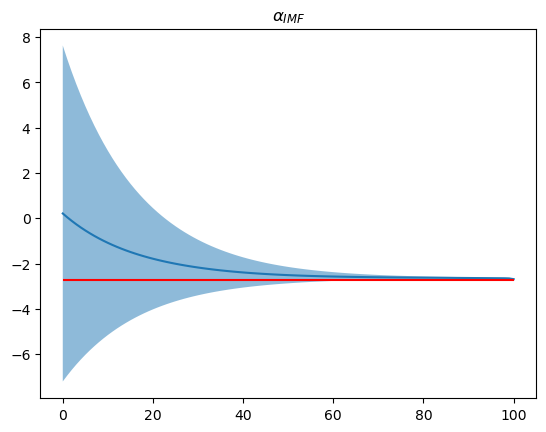

In [14]:
x = np.arange(0,model.timesteps+1)
y = model.x_t[0,:,:,0].detach().numpy().mean(axis=1)
yerr = model.x_t[0,:,:,0].detach().numpy().std(axis=1)

plt.plot(x,y)
plt.fill_between(x, y-yerr, y+yerr, alpha=0.5)
plt.hlines(val_data[0,0], 0, model.timesteps, color='red')
plt.title(r"$\alpha_{IMF}$")
plt.show()

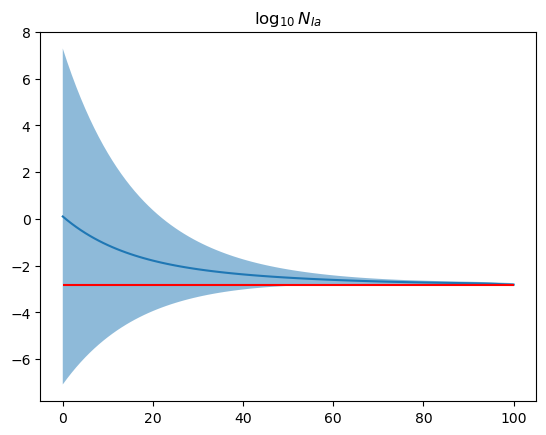

In [15]:
x = np.arange(0,model.timesteps+1)
y = model.x_t[0,:,:,1].detach().numpy().mean(axis=1)
yerr = model.x_t[0,:,:,1].detach().numpy().std(axis=1)

plt.plot(x,y)
plt.fill_between(x, y-yerr, y+yerr, alpha=0.5)
plt.hlines(val_data[0,1], 0, model.timesteps, color='red')
plt.title(r"$\log_{10}N_{Ia}$")
plt.show()

In [8]:
data_loader = DataLoader(data, batch_size=1000, shuffle=False)
p3=model.sample(data_loader, condition_mask=mask, device=device).to("cpu")

100%|██████████| 1000/1000 [04:23<00:00,  3.79it/s]


In [9]:
torch.mean(100*torch.abs((val_data[:1000]-p3.mean(axis=1))/val_data[:1000]), axis=0)[:6]

tensor([  3.7091,   4.2631, 347.1995,  16.5688,  19.7966,  31.2743])

In [ ]:
"""
denoising_data = model.x_t.detach().numpy()

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 500  
plt.ioff()
fig, ax = plt.subplots()

def animate(i):
    plt.clf()
    plt.xlim(-3,-1)
    plt.ylim(-3.5,-1.5)
    plt.xlabel(r'$\alpha_{IMF}$')
    plt.ylabel(r'$\log_{10}N$')
    plt.title(f'Denoising Timestep: {i}')
    
    sns.set_style("white")
    sns.kdeplot(x=denoising_data[0,i,:,0], y=denoising_data[0,i,:,1], cmap='Blues', fill=True, bw_adjust=0.8)
    plt.tight_layout()

ani2 = matplotlib.animation.FuncAnimation(fig, animate, frames=model.timesteps+1) 

writer = matplotlib.animation.PillowWriter(fps=10,
                                bitrate=-1)

ani2.save('plots/test_new.gif', writer=writer)
"""

In [11]:
from scipy.stats import gaussian_kde

In [12]:
def log_prob(samples, theta):
    kde = gaussian_kde(samples.T.numpy())
    return kde.logpdf(theta).item()

In [14]:
log_probs = np.array([log_prob(p3[i,:,:6], val_data[i,:6]) for i in range(len(p3))])

/export/home/bguenes/anaconda3/envs/simformer_torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [51]:
log_probs.min()

-326938.85480544757

In [52]:
log_probs.argmin()

343

In [53]:
log_probs.max()

-136.05863871338588

In [54]:
log_probs.argmax()

215

In [56]:
np.mean(log_probs)

-37281.52372259315

In [19]:
from src.metrics import PosteriorCoverage

In [39]:
plot_hist = ["coverage", "histogram", "predictions", "tarp"]
labels_in = [r"$\alpha_{IMF}$", "$log_{10}N_{1a}$", "$log_{10}SFE$", "$log_{10}SFR", "$x_{out}$", "Time"]
metric = PosteriorCoverage(
    num_samples=1000, sample_method="direct",
    labels=labels_in,
    plot_list = plot_hist
)

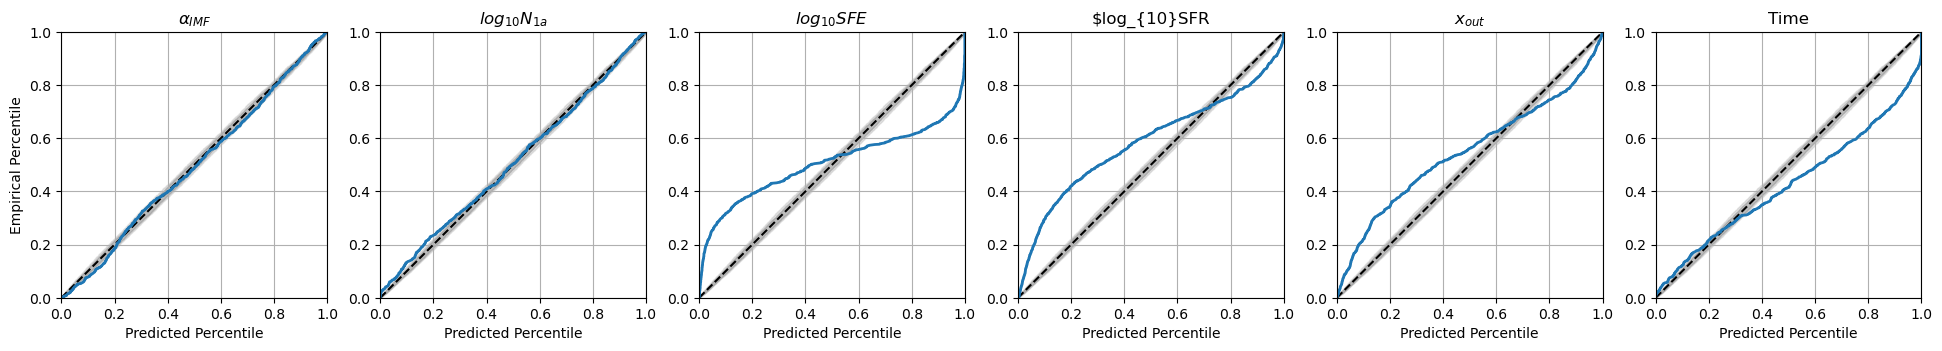

In [63]:
metric._plot_coverage(p3[:,:,:6], val_data[:len(p3),:6],"")

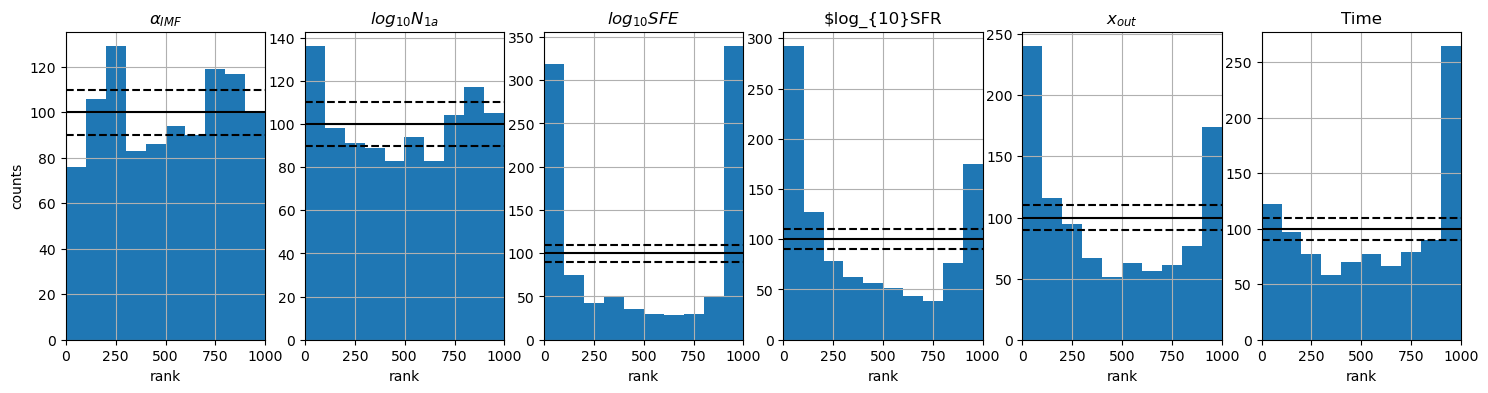

In [ ]:
metric._plot_ranks_histogram(p3[:,:,:6], val_data[:len(p3),:6],"")

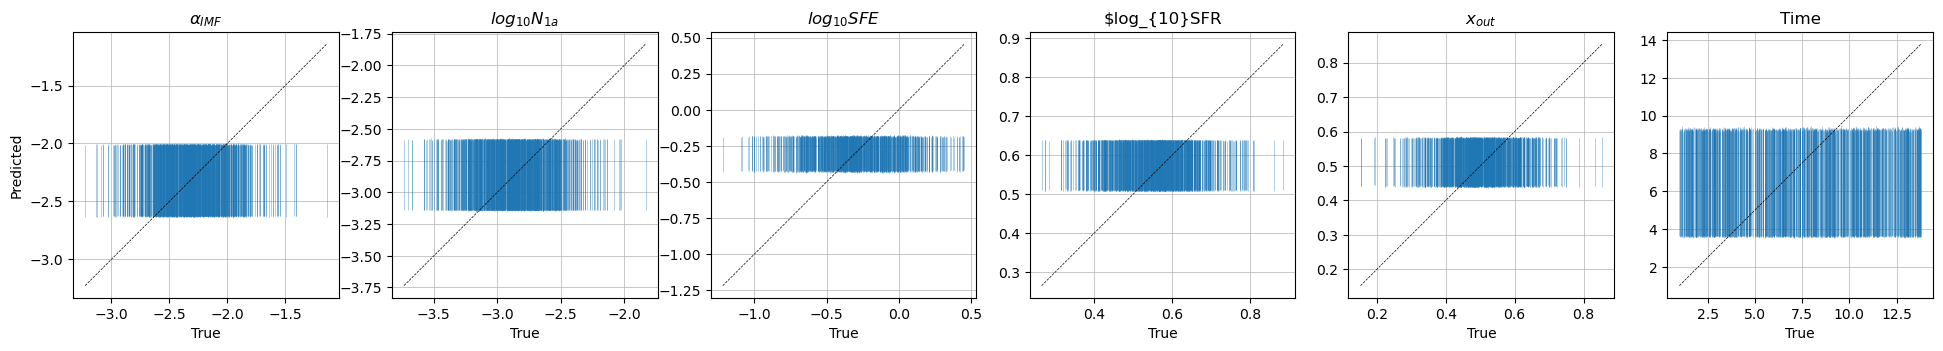

In [64]:
metric._plot_predictions(p3[:,:,:6].numpy(), val_data[:len(p3),:6].numpy(),"")

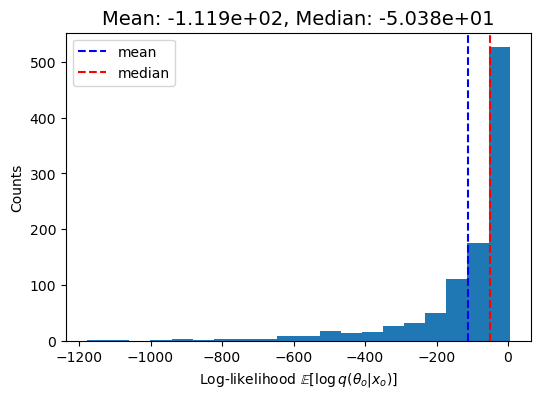

In [ ]:
metric._calc_true_logprob(p3[:,:,:6], val_data[:len(p3),:6],"")[0]

100%|██████████| 100/100 [00:08<00:00, 12.44it/s]


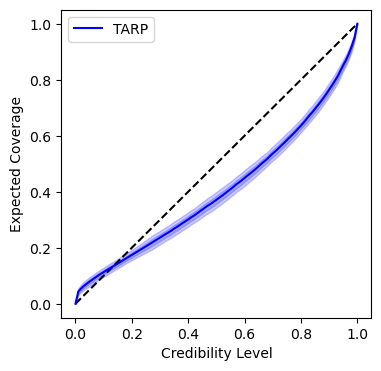

In [ ]:
metric._plot_TARP(p3[:,:,:6].numpy(), val_data[:len(p3),:6].numpy(),"",
                                        references="random", metric="euclidean",
                                        num_alpha_bins=None,
                                        num_bootstrap=100,
                                        norm=True, bootstrap=True)